<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/confirm_label_noize_for_cm_data/eras/confirm_label/analyze_results_of_KTH_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境設定

In [1]:
## import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep
# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks
# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
# others
import json
from collections import OrderedDict
import pprint
import re
from IPython.display import clear_output


#Historyデータの用意

In [2]:
## gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")

## colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")

Mounted at /content/drive
Created at /content/desk


In [3]:
path_KTH_Histories = "/content/drive/MyDrive/colab/histories/KTH_robust"
all_history_directories = os.listdir(path_KTH_Histories)
all_history_directories = sorted(all_history_directories)
print("Pick up one key from the below directories")
for key, each_noize_histories in enumerate(all_history_directories):
  print(each_noize_histories, "key:", key)

pick_key = int(input())

clear_output()
print("The key is", pick_key, "and", all_history_directories[pick_key])

The key is 0 and noize=0


In [75]:
path_pickup_histories = path.join(path_KTH_Histories, all_history_directories[pick_key])

each_loss_pattern = r"KTH\.(\d+\.)+\w+"

used_losses = []

if path.isdir(path_pickup_histories):
  print("expand", path_pickup_histories)
  partial_histories = os.listdir(path_pickup_histories)
  partial_histories = sorted(partial_histories)

  count_each = 0
  each_loss_header_old = ""
  some_histories = []
  each_loss_histories = []

  for i, each_history in enumerate(partial_histories):
    each_loss_header = re.match(each_loss_pattern, each_history).group()
    each_loss_header = re.sub('KTH.0.', '', each_loss_header)

    if each_loss_header != each_loss_header_old and each_loss_header_old != "": # change different loss
      # update for the next loss
      some_histories.append(each_loss_histories)
      used_losses.append(each_loss_header_old)

      count_each = 0
      each_loss_histories = []
      print("------------------------------------------------------------------------------")

    else:
      pass
    
    the_history = pd.read_csv(path.join(path_pickup_histories, each_history))
    each_loss_histories.append(the_history)
      

    print(each_loss_header, "-", count_each+1, "@", i+1)
    count_each += 1
    each_loss_header_old = each_loss_header

    if (i+1) == len(partial_histories): # when the last element
      some_histories.append(each_loss_histories)
      used_losses.append(each_loss_header)
    else:
      pass


expand /content/drive/MyDrive/colab/histories/KTH_robust/noize=0
CategoricalCrossentropy - 1 @ 1
CategoricalCrossentropy - 2 @ 2
CategoricalCrossentropy - 3 @ 3
CategoricalCrossentropy - 4 @ 4
CategoricalCrossentropy - 5 @ 5
CategoricalCrossentropy - 6 @ 6
------------------------------------------------------------------------------
MeanAbsoluteError - 1 @ 7
MeanAbsoluteError - 2 @ 8
MeanAbsoluteError - 3 @ 9
MeanAbsoluteError - 4 @ 10
MeanAbsoluteError - 5 @ 11
MeanAbsoluteError - 6 @ 12
------------------------------------------------------------------------------
MeanSquaredError - 1 @ 13
MeanSquaredError - 2 @ 14
MeanSquaredError - 3 @ 15
MeanSquaredError - 4 @ 16
MeanSquaredError - 5 @ 17
MeanSquaredError - 6 @ 18


In [78]:
print("used in the experiment as loss function :")
print(used_losses)

used in the experiment as loss function :
['CategoricalCrossentropy', 'MeanAbsoluteError', 'MeanSquaredError']


In [ ]:
for i in range(6):
  plot_learning(some_histories[1][i], experiment_name="No name")

0.0-CategoricalCrossentropy


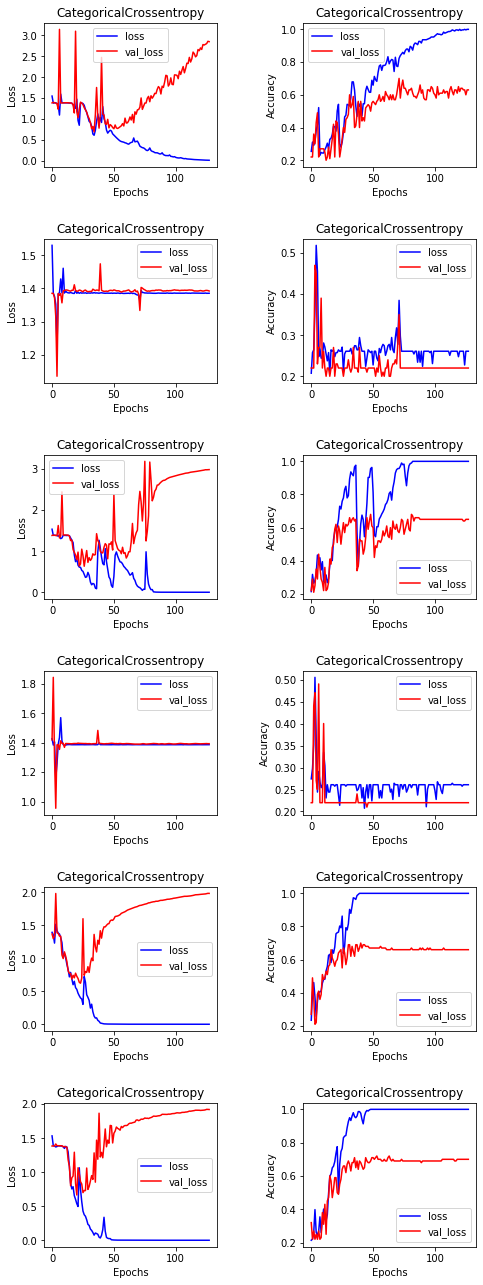

In [96]:
noize_rate = 0.0
noize_rate = str(noize_rate)

WIDTH = 8
HEIGHT = 10



for key_loss, each_loss in enumerate(used_losses):
  # 図のインスタンス作成
  fig = plt.figure(figsize=(WIDTH, HEIGHT))

  ## 図にグラフをプロット
  k = 1
  rate = 1.5  # プロットのための係数
  for row in range(6):
    # LOSS part
    ## set
    LOSS_plt = fig.add_subplot(6, 2, k)
    LOSS_plt.set_position([0.3*1*rate, 0.2*row*rate, 0.3, 0.2])
    LOSS_plt.set_title(each_loss)
    LOSS_plt.set_xlabel('Epochs')
    LOSS_plt.set_ylabel('Loss')
    ## plot 
    loss = some_histories[key_loss][row]["loss"] 
    val_loss = some_histories[key_loss][row]["val_loss"]
    LOSS_plt.plot(loss, label='loss', color='blue') # plot loss
    LOSS_plt.plot(val_loss, label='val_loss', color='red') # plot val_loss
    LOSS_plt.legend(loc='best')

    k+=1

    # ACC part
    ## set
    ACC_plt = fig.add_subplot(6, 2, k)
    ACC_plt.set_position([0.3*2*rate, 0.2*row*rate, 0.3, 0.2])
    ACC_plt.set_title(each_loss)
    ACC_plt.set_xlabel('Epochs')
    ACC_plt.set_ylabel('Accuracy')
    ## plot 
    acc = some_histories[key_loss][row]["acc"] 
    val_acc = some_histories[key_loss][row]["val_acc"]
    ACC_plt.plot(acc, label='loss', color='blue') # plot acc
    ACC_plt.plot(val_acc, label='val_loss', color='red') # plot val_loss
    ACC_plt.legend(loc='best')
    k += 1

  #save
  
  # save_dir = os.path.join(desk, experiment_name)
  # if not os.path.exists(save_dir):
  #   os.mkdir(save_dir)

  # path_image = os.path.join(save_dir, useLoss+experiment_name)
  # fig.savefig(path_image, bbox_inches='tight')
  print("noize="noize_rate + each_loss)

  break


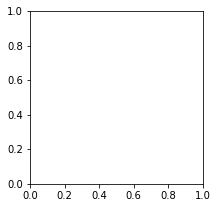

In [28]:
fig = plt.figure(figsize=(6.0, 3.0))
ax = fig.add_subplot(111)

ax.set_position([0.5,0.1,0.4,0.8])
plt.show()